In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch = [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A=loadgraph()
        elif recon:
            E1,E2,A=loadgraph(recon=True, train=False,run=run,t_r=j)
            print('recon')
        else:
            E1,E2,A=loadgraph(train=False)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    return src1_batch, src2_batch,y_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,11)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(14)
        id1 = id[tt==t].astype(int)
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
        
        A=A[id1-1]
        #print(A)
        A=A[:,id2-1]
        #print(A)
        
        
    elif recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        id2 = id[tt==(t+1)].astype(int)
        E1 = E[id1-1]
        E2 = E[id2-1]
        
        A=A[id1-1]
        #print(A)
        A=A[:,id2-1]
        
       
        #print(E1,E2)
    else:
        if run==None:
            run=np.random.randint(11,15)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = np.random.randint(14)
        id1 = id[tt==t].astype(int)
        id2 = id[tt==(t+1)].astype(int)
        E1 = E[id1-1]
        E2 = E[id2-1]
        
        A=A[id1-1]
        #print(A)
        A=A[:,id2-1]
        #print(run,t,id1,id2)
        #print(E1,E2)
        
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A) 
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask


def train_easy(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    model.train()
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        print(i)
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src1, src2, y = collate_fn(10,-100)
        
        #print('src_batch',src1)
        #print('src_batch s',src1.size())
        
        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output1,output2 = model(src1,src2,src_padding_mask1,src_padding_mask2)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        #print('out1',output1,output1.size())
        #print('out2',output2,output2.size())
        
        

 
        #print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = loss_function(output1, src1)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        i=i+1
        
        '''
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(easy=True)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error
    '''
        
        
class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y = collate_fn(26,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    loss.backward()

    optimizer.step()
    losses += loss.item()

    return losses / len(src1)



class Loss():
    def __init__(self,pen):
        self.pen=pen
        
    def loss (self,Ad,y):
        
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        
        return loss
    


def evaluate(model,loss_fn):
    model.eval()
    losses = 0

    src1, src2, y = collate_fn(26,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)


def postprocess(A):
    pp_A=[]
    for i in range(len(A)):
        ind=torch.argmax(A[i], dim=0)
        B=np.zeros(A[i].shape)
        for j in range(len(ind)):
            B[ind[j],j]=1
        pp_A.append(B)
    return pp_A

def square(m):
    return m.shape[0] == m.shape[1]


def postprocess_2(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
        else:
            z2 = np.zeros(Ad[h].shape)
            zero_col=np.where(~z.any(axis=0))[0]
            ind=torch.argmax(Ad[h][:,zero_col], dim=0)
            for k,l in zip(ind,zero_col):
                z2[k,l]=1
            pp_A.append(z+z2)  
        
    return pp_A


def make_reconstructed_edgelist(A,run):
    
    e_start=[1,2,3]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        
        
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                if M[z,j]!=0:
                    print(z,e_start)
                    e1.append(int(e_start[z]))
                    e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                    print('e',e_mid)
                    e2.append(int(e_mid[j]))
        
        e_start=e_mid
        print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0



In [3]:
#loadgraph()

In [4]:
class AdjacencyTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AdjacencyTransformer, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        src1_emb = self.positional_encoding(src_t1)
        src2_emb = self.positional_encoding(src_t2)
        #print('trans_src',src1_emb,src1_emb.size())
        #print('trans_src_padd',src_padding_mask1,src_padding_mask1.size())
        out1 = self.encoder(src1_emb,src_key_padding_mask=src_padding_mask1)
        out2 = self.encoder(src2_emb,src_key_padding_mask=src_padding_mask2)
        
        out_dec1=self.decoder(out2, out1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        
        #out_dec2=self.decoder(out1, out2,tgt_key_padding_mask=src_padding_mask1,memory_key_padding_mask=src_padding_mask2)
        out_dec2=out1
        #out1=torch.transpose(out1,0,1)
        #out2=torch.transpose(out2,0,1)
        #out2=torch.transpose(out2,1,2)
        
        #z=self.sig(torch.bmm(out1,out2))
        
        out_dec2=torch.transpose(out_dec2,0,1)
        out_dec1=torch.transpose(out_dec1,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        return Ad

In [5]:
emb_size= 24
nhead= 6
num_encoder_layers = 3


transformer = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [6]:
from timeit import default_timer as timer
NUM_EPOCHS = 2000

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 4.120, Val loss: 3.399, Epoch time = 1.344s
Epoch: 2, Train loss: 5.322, Val loss: 3.900, Epoch time = 1.650s
Epoch: 3, Train loss: 4.733, Val loss: 3.428, Epoch time = 1.564s
Epoch: 4, Train loss: 4.289, Val loss: 5.594, Epoch time = 1.392s
Epoch: 5, Train loss: 4.611, Val loss: 3.796, Epoch time = 1.500s
Epoch: 6, Train loss: 3.919, Val loss: 3.753, Epoch time = 1.457s
Epoch: 7, Train loss: 4.217, Val loss: 3.452, Epoch time = 1.276s
Epoch: 8, Train loss: 4.978, Val loss: 3.998, Epoch time = 1.506s
Epoch: 9, Train loss: 4.627, Val loss: 3.778, Epoch time = 1.628s
Epoch: 10, Train loss: 4.905, Val loss: 3.851, Epoch time = 1.479s
Epoch: 11, Train loss: 4.678, Val loss: 3.748, Epoch time = 1.506s
Epoch: 12, Train loss: 4.094, Val loss: 3.593, Epoch time = 1.405s
Epoch: 13, Train loss: 4.767, Val loss: 4.025, Epoch time = 1.572s
Epoch: 14, Train loss: 4.569, Val loss: 3.684, Epoch time = 1.476s
Epoch: 15, Train loss: 4.287, Val loss: 3.428, Epoch time = 1.681s
Epoc

Epoch: 124, Train loss: 4.675, Val loss: 3.408, Epoch time = 1.736s
Epoch: 125, Train loss: 4.298, Val loss: 3.337, Epoch time = 1.639s
Epoch: 126, Train loss: 4.187, Val loss: 3.274, Epoch time = 1.496s
Epoch: 127, Train loss: 4.353, Val loss: 3.141, Epoch time = 1.790s
Epoch: 128, Train loss: 4.874, Val loss: 3.551, Epoch time = 1.656s
Epoch: 129, Train loss: 4.282, Val loss: 3.427, Epoch time = 1.656s
Epoch: 130, Train loss: 4.341, Val loss: 3.157, Epoch time = 1.556s
Epoch: 131, Train loss: 4.581, Val loss: 3.602, Epoch time = 1.465s
Epoch: 132, Train loss: 4.285, Val loss: 3.503, Epoch time = 1.641s
Epoch: 133, Train loss: 4.238, Val loss: 3.861, Epoch time = 1.728s
Epoch: 134, Train loss: 4.261, Val loss: 4.053, Epoch time = 1.527s
Epoch: 135, Train loss: 3.784, Val loss: 3.243, Epoch time = 1.485s
Epoch: 136, Train loss: 3.780, Val loss: 3.500, Epoch time = 1.528s
Epoch: 137, Train loss: 3.738, Val loss: 3.791, Epoch time = 1.460s
Epoch: 138, Train loss: 4.185, Val loss: 3.692, 

Epoch: 245, Train loss: 3.737, Val loss: 3.530, Epoch time = 1.437s
Epoch: 246, Train loss: 3.307, Val loss: 3.704, Epoch time = 1.538s
Epoch: 247, Train loss: 4.653, Val loss: 3.163, Epoch time = 1.550s
Epoch: 248, Train loss: 3.852, Val loss: 3.031, Epoch time = 1.541s
Epoch: 249, Train loss: 4.462, Val loss: 3.461, Epoch time = 1.424s
Epoch: 250, Train loss: 4.026, Val loss: 3.456, Epoch time = 1.316s
Epoch: 251, Train loss: 3.459, Val loss: 3.513, Epoch time = 1.411s
Epoch: 252, Train loss: 4.085, Val loss: 2.999, Epoch time = 1.432s
Epoch: 253, Train loss: 3.779, Val loss: 3.337, Epoch time = 1.363s
Epoch: 254, Train loss: 4.141, Val loss: 3.158, Epoch time = 1.422s
Epoch: 255, Train loss: 3.662, Val loss: 2.909, Epoch time = 1.626s
Epoch: 256, Train loss: 3.763, Val loss: 3.129, Epoch time = 1.406s
Epoch: 257, Train loss: 4.510, Val loss: 3.702, Epoch time = 1.543s
Epoch: 258, Train loss: 4.440, Val loss: 3.698, Epoch time = 1.464s
Epoch: 259, Train loss: 4.276, Val loss: 3.613, 

Epoch: 366, Train loss: 3.665, Val loss: 3.102, Epoch time = 1.564s
Epoch: 367, Train loss: 3.834, Val loss: 3.347, Epoch time = 1.545s
Epoch: 368, Train loss: 3.502, Val loss: 3.277, Epoch time = 1.318s
Epoch: 369, Train loss: 3.475, Val loss: 3.515, Epoch time = 1.540s
Epoch: 370, Train loss: 3.208, Val loss: 3.332, Epoch time = 1.422s
Epoch: 371, Train loss: 3.394, Val loss: 3.586, Epoch time = 1.286s
Epoch: 372, Train loss: 4.078, Val loss: 3.806, Epoch time = 1.491s
Epoch: 373, Train loss: 3.563, Val loss: 3.057, Epoch time = 1.539s
Epoch: 374, Train loss: 3.818, Val loss: 3.657, Epoch time = 1.633s
Epoch: 375, Train loss: 3.324, Val loss: 3.451, Epoch time = 1.712s
Epoch: 376, Train loss: 3.608, Val loss: 3.367, Epoch time = 1.427s
Epoch: 377, Train loss: 4.016, Val loss: 3.373, Epoch time = 1.663s
Epoch: 378, Train loss: 3.522, Val loss: 3.297, Epoch time = 1.539s
Epoch: 379, Train loss: 3.677, Val loss: 3.573, Epoch time = 1.553s
Epoch: 380, Train loss: 3.593, Val loss: 3.217, 

Epoch: 487, Train loss: 3.520, Val loss: 3.081, Epoch time = 1.684s
Epoch: 488, Train loss: 3.227, Val loss: 3.205, Epoch time = 1.465s
Epoch: 489, Train loss: 4.204, Val loss: 3.372, Epoch time = 1.524s
Epoch: 490, Train loss: 3.388, Val loss: 4.450, Epoch time = 1.526s
Epoch: 491, Train loss: 3.753, Val loss: 3.673, Epoch time = 1.644s
Epoch: 492, Train loss: 3.663, Val loss: 3.139, Epoch time = 1.632s
Epoch: 493, Train loss: 3.516, Val loss: 3.408, Epoch time = 1.449s
Epoch: 494, Train loss: 3.781, Val loss: 2.927, Epoch time = 1.473s
Epoch: 495, Train loss: 3.969, Val loss: 4.764, Epoch time = 1.649s
Epoch: 496, Train loss: 3.749, Val loss: 3.405, Epoch time = 1.645s
Epoch: 497, Train loss: 3.719, Val loss: 3.100, Epoch time = 1.620s
Epoch: 498, Train loss: 3.617, Val loss: 3.411, Epoch time = 1.606s
Epoch: 499, Train loss: 3.421, Val loss: 2.971, Epoch time = 1.702s
Epoch: 500, Train loss: 3.809, Val loss: 3.384, Epoch time = 1.712s
Epoch: 501, Train loss: 3.211, Val loss: 3.708, 

Epoch: 608, Train loss: 3.505, Val loss: 2.911, Epoch time = 1.732s
Epoch: 609, Train loss: 3.383, Val loss: 3.141, Epoch time = 1.648s
Epoch: 610, Train loss: 3.576, Val loss: 3.538, Epoch time = 1.509s
Epoch: 611, Train loss: 3.532, Val loss: 3.216, Epoch time = 1.718s
Epoch: 612, Train loss: 3.357, Val loss: 3.068, Epoch time = 1.494s
Epoch: 613, Train loss: 3.653, Val loss: 2.949, Epoch time = 1.653s
Epoch: 614, Train loss: 3.442, Val loss: 3.129, Epoch time = 1.608s
Epoch: 615, Train loss: 3.452, Val loss: 3.320, Epoch time = 1.566s
Epoch: 616, Train loss: 3.451, Val loss: 2.883, Epoch time = 1.651s
Epoch: 617, Train loss: 3.339, Val loss: 2.928, Epoch time = 1.650s
Epoch: 618, Train loss: 2.728, Val loss: 3.250, Epoch time = 1.309s
Epoch: 619, Train loss: 3.556, Val loss: 3.093, Epoch time = 1.695s
Epoch: 620, Train loss: 3.181, Val loss: 3.460, Epoch time = 1.523s
Epoch: 621, Train loss: 3.073, Val loss: 3.263, Epoch time = 1.539s
Epoch: 622, Train loss: 3.585, Val loss: 2.828, 

Epoch: 729, Train loss: 3.880, Val loss: 2.987, Epoch time = 1.606s
Epoch: 730, Train loss: 3.483, Val loss: 3.414, Epoch time = 1.516s
Epoch: 731, Train loss: 3.877, Val loss: 3.185, Epoch time = 1.508s
Epoch: 732, Train loss: 3.753, Val loss: 3.335, Epoch time = 1.615s
Epoch: 733, Train loss: 3.541, Val loss: 3.477, Epoch time = 1.593s
Epoch: 734, Train loss: 2.886, Val loss: 3.294, Epoch time = 1.519s
Epoch: 735, Train loss: 3.680, Val loss: 3.863, Epoch time = 1.351s
Epoch: 736, Train loss: 3.595, Val loss: 3.232, Epoch time = 1.610s
Epoch: 737, Train loss: 3.666, Val loss: 3.389, Epoch time = 1.549s
Epoch: 738, Train loss: 3.863, Val loss: 3.098, Epoch time = 1.616s
Epoch: 739, Train loss: 3.381, Val loss: 3.234, Epoch time = 1.581s
Epoch: 740, Train loss: 3.422, Val loss: 2.998, Epoch time = 1.409s
Epoch: 741, Train loss: 3.672, Val loss: 2.883, Epoch time = 1.431s
Epoch: 742, Train loss: 3.630, Val loss: 3.164, Epoch time = 1.560s
Epoch: 743, Train loss: 3.672, Val loss: 3.394, 

Epoch: 850, Train loss: 3.780, Val loss: 3.364, Epoch time = 1.580s
Epoch: 851, Train loss: 3.129, Val loss: 2.896, Epoch time = 1.729s
Epoch: 852, Train loss: 3.237, Val loss: 2.787, Epoch time = 1.522s
Epoch: 853, Train loss: 3.944, Val loss: 3.098, Epoch time = 1.802s
Epoch: 854, Train loss: 4.370, Val loss: 4.191, Epoch time = 1.310s
Epoch: 855, Train loss: 3.868, Val loss: 3.163, Epoch time = 1.537s
Epoch: 856, Train loss: 3.268, Val loss: 3.238, Epoch time = 1.769s
Epoch: 857, Train loss: 3.586, Val loss: 3.084, Epoch time = 1.498s
Epoch: 858, Train loss: 3.362, Val loss: 3.021, Epoch time = 1.737s
Epoch: 859, Train loss: 3.970, Val loss: 3.116, Epoch time = 1.622s
Epoch: 860, Train loss: 3.487, Val loss: 3.242, Epoch time = 1.511s
Epoch: 861, Train loss: 3.256, Val loss: 3.089, Epoch time = 1.542s
Epoch: 862, Train loss: 3.848, Val loss: 2.850, Epoch time = 1.553s
Epoch: 863, Train loss: 3.830, Val loss: 3.054, Epoch time = 1.625s
Epoch: 864, Train loss: 3.807, Val loss: 3.873, 

Epoch: 971, Train loss: 3.715, Val loss: 3.588, Epoch time = 1.647s
Epoch: 972, Train loss: 3.129, Val loss: 3.029, Epoch time = 1.694s
Epoch: 973, Train loss: 2.931, Val loss: 2.825, Epoch time = 1.431s
Epoch: 974, Train loss: 3.518, Val loss: 3.266, Epoch time = 1.606s
Epoch: 975, Train loss: 3.435, Val loss: 2.975, Epoch time = 1.676s
Epoch: 976, Train loss: 4.422, Val loss: 3.118, Epoch time = 1.721s
Epoch: 977, Train loss: 3.333, Val loss: 2.588, Epoch time = 1.593s
Epoch: 978, Train loss: 3.573, Val loss: 3.096, Epoch time = 1.573s
Epoch: 979, Train loss: 3.170, Val loss: 3.138, Epoch time = 1.559s
Epoch: 980, Train loss: 3.805, Val loss: 3.081, Epoch time = 1.560s
Epoch: 981, Train loss: 3.807, Val loss: 2.953, Epoch time = 1.702s
Epoch: 982, Train loss: 3.678, Val loss: 2.865, Epoch time = 1.423s
Epoch: 983, Train loss: 3.137, Val loss: 4.145, Epoch time = 1.472s
Epoch: 984, Train loss: 3.867, Val loss: 3.043, Epoch time = 1.564s
Epoch: 985, Train loss: 3.918, Val loss: 3.285, 

Epoch: 1091, Train loss: 3.673, Val loss: 2.940, Epoch time = 1.622s
Epoch: 1092, Train loss: 3.033, Val loss: 3.091, Epoch time = 1.417s
Epoch: 1093, Train loss: 3.223, Val loss: 2.781, Epoch time = 1.401s
Epoch: 1094, Train loss: 3.444, Val loss: 3.103, Epoch time = 1.515s
Epoch: 1095, Train loss: 3.067, Val loss: 4.379, Epoch time = 1.449s
Epoch: 1096, Train loss: 3.522, Val loss: 3.116, Epoch time = 1.599s
Epoch: 1097, Train loss: 3.398, Val loss: 2.922, Epoch time = 1.468s
Epoch: 1098, Train loss: 3.527, Val loss: 2.769, Epoch time = 1.498s
Epoch: 1099, Train loss: 3.163, Val loss: 2.797, Epoch time = 1.896s
Epoch: 1100, Train loss: 3.080, Val loss: 2.848, Epoch time = 1.447s
Epoch: 1101, Train loss: 3.401, Val loss: 3.165, Epoch time = 1.449s
Epoch: 1102, Train loss: 3.740, Val loss: 3.363, Epoch time = 1.653s
Epoch: 1103, Train loss: 3.189, Val loss: 2.992, Epoch time = 1.375s
Epoch: 1104, Train loss: 3.327, Val loss: 3.184, Epoch time = 1.547s
Epoch: 1105, Train loss: 3.198, Va

Epoch: 1210, Train loss: 3.286, Val loss: 2.912, Epoch time = 1.681s
Epoch: 1211, Train loss: 3.314, Val loss: 2.860, Epoch time = 1.655s
Epoch: 1212, Train loss: 4.038, Val loss: 2.983, Epoch time = 1.613s
Epoch: 1213, Train loss: 3.100, Val loss: 2.525, Epoch time = 1.546s
Epoch: 1214, Train loss: 3.664, Val loss: 3.069, Epoch time = 1.500s
Epoch: 1215, Train loss: 3.341, Val loss: 2.917, Epoch time = 1.593s
Epoch: 1216, Train loss: 3.792, Val loss: 2.814, Epoch time = 1.512s
Epoch: 1217, Train loss: 3.187, Val loss: 3.137, Epoch time = 1.513s
Epoch: 1218, Train loss: 3.483, Val loss: 2.879, Epoch time = 1.488s
Epoch: 1219, Train loss: 3.024, Val loss: 2.779, Epoch time = 1.610s
Epoch: 1220, Train loss: 3.401, Val loss: 2.912, Epoch time = 1.717s
Epoch: 1221, Train loss: 3.253, Val loss: 2.670, Epoch time = 1.445s
Epoch: 1222, Train loss: 3.074, Val loss: 3.140, Epoch time = 1.693s
Epoch: 1223, Train loss: 3.362, Val loss: 3.244, Epoch time = 1.768s
Epoch: 1224, Train loss: 3.199, Va

Epoch: 1329, Train loss: 3.553, Val loss: 3.024, Epoch time = 1.631s
Epoch: 1330, Train loss: 3.758, Val loss: 3.325, Epoch time = 1.469s
Epoch: 1331, Train loss: 3.786, Val loss: 3.283, Epoch time = 1.371s
Epoch: 1332, Train loss: 3.284, Val loss: 2.972, Epoch time = 1.559s
Epoch: 1333, Train loss: 3.047, Val loss: 2.733, Epoch time = 1.386s
Epoch: 1334, Train loss: 2.901, Val loss: 3.065, Epoch time = 1.694s
Epoch: 1335, Train loss: 3.155, Val loss: 3.309, Epoch time = 1.711s
Epoch: 1336, Train loss: 3.326, Val loss: 2.942, Epoch time = 1.518s
Epoch: 1337, Train loss: 3.816, Val loss: 2.997, Epoch time = 1.539s
Epoch: 1338, Train loss: 3.507, Val loss: 3.064, Epoch time = 1.699s
Epoch: 1339, Train loss: 3.322, Val loss: 2.741, Epoch time = 1.641s
Epoch: 1340, Train loss: 3.366, Val loss: 4.375, Epoch time = 1.878s
Epoch: 1341, Train loss: 3.845, Val loss: 2.780, Epoch time = 1.577s
Epoch: 1342, Train loss: 3.925, Val loss: 4.369, Epoch time = 1.677s
Epoch: 1343, Train loss: 3.064, Va

Epoch: 1448, Train loss: 3.016, Val loss: 2.976, Epoch time = 1.667s
Epoch: 1449, Train loss: 2.857, Val loss: 2.761, Epoch time = 1.581s
Epoch: 1450, Train loss: 3.031, Val loss: 3.175, Epoch time = 1.733s
Epoch: 1451, Train loss: 2.857, Val loss: 2.760, Epoch time = 1.643s
Epoch: 1452, Train loss: 3.513, Val loss: 2.985, Epoch time = 1.561s
Epoch: 1453, Train loss: 2.851, Val loss: 3.003, Epoch time = 1.533s
Epoch: 1454, Train loss: 3.330, Val loss: 2.978, Epoch time = 1.488s
Epoch: 1455, Train loss: 3.136, Val loss: 2.811, Epoch time = 1.666s
Epoch: 1456, Train loss: 3.199, Val loss: 2.796, Epoch time = 1.877s
Epoch: 1457, Train loss: 3.334, Val loss: 3.045, Epoch time = 1.632s
Epoch: 1458, Train loss: 3.353, Val loss: 3.862, Epoch time = 1.750s
Epoch: 1459, Train loss: 3.721, Val loss: 2.782, Epoch time = 1.788s
Epoch: 1460, Train loss: 2.965, Val loss: 2.714, Epoch time = 1.394s
Epoch: 1461, Train loss: 3.549, Val loss: 3.254, Epoch time = 1.623s
Epoch: 1462, Train loss: 3.784, Va

Epoch: 1567, Train loss: 3.670, Val loss: 2.854, Epoch time = 1.553s
Epoch: 1568, Train loss: 3.327, Val loss: 2.998, Epoch time = 1.638s
Epoch: 1569, Train loss: 2.978, Val loss: 2.750, Epoch time = 1.483s
Epoch: 1570, Train loss: 3.036, Val loss: 3.236, Epoch time = 1.724s
Epoch: 1571, Train loss: 3.470, Val loss: 2.828, Epoch time = 1.860s
Epoch: 1572, Train loss: 2.963, Val loss: 2.929, Epoch time = 1.589s
Epoch: 1573, Train loss: 3.908, Val loss: 2.973, Epoch time = 1.642s
Epoch: 1574, Train loss: 3.105, Val loss: 2.878, Epoch time = 1.642s
Epoch: 1575, Train loss: 3.172, Val loss: 2.862, Epoch time = 1.579s
Epoch: 1576, Train loss: 3.356, Val loss: 2.961, Epoch time = 1.782s
Epoch: 1577, Train loss: 3.747, Val loss: 3.037, Epoch time = 1.691s
Epoch: 1578, Train loss: 3.505, Val loss: 2.789, Epoch time = 1.675s
Epoch: 1579, Train loss: 4.175, Val loss: 3.340, Epoch time = 1.796s
Epoch: 1580, Train loss: 3.717, Val loss: 2.768, Epoch time = 1.735s
Epoch: 1581, Train loss: 3.392, Va

Epoch: 1686, Train loss: 2.810, Val loss: 2.811, Epoch time = 1.414s
Epoch: 1687, Train loss: 2.966, Val loss: 3.061, Epoch time = 1.539s
Epoch: 1688, Train loss: 3.624, Val loss: 3.038, Epoch time = 1.625s
Epoch: 1689, Train loss: 3.345, Val loss: 3.050, Epoch time = 1.533s
Epoch: 1690, Train loss: 3.386, Val loss: 3.117, Epoch time = 1.641s
Epoch: 1691, Train loss: 3.361, Val loss: 2.644, Epoch time = 1.868s
Epoch: 1692, Train loss: 3.351, Val loss: 2.610, Epoch time = 1.941s
Epoch: 1693, Train loss: 3.663, Val loss: 2.641, Epoch time = 1.495s
Epoch: 1694, Train loss: 3.012, Val loss: 2.845, Epoch time = 1.803s
Epoch: 1695, Train loss: 3.355, Val loss: 2.788, Epoch time = 1.562s
Epoch: 1696, Train loss: 2.825, Val loss: 2.678, Epoch time = 1.558s
Epoch: 1697, Train loss: 3.758, Val loss: 2.946, Epoch time = 1.858s
Epoch: 1698, Train loss: 2.985, Val loss: 2.895, Epoch time = 1.874s
Epoch: 1699, Train loss: 3.235, Val loss: 2.705, Epoch time = 1.782s
Epoch: 1700, Train loss: 2.895, Va

Epoch: 1805, Train loss: 3.350, Val loss: 2.822, Epoch time = 1.479s
Epoch: 1806, Train loss: 3.495, Val loss: 2.876, Epoch time = 1.757s
Epoch: 1807, Train loss: 3.034, Val loss: 3.259, Epoch time = 1.649s
Epoch: 1808, Train loss: 3.422, Val loss: 2.800, Epoch time = 1.537s
Epoch: 1809, Train loss: 3.439, Val loss: 3.100, Epoch time = 1.774s
Epoch: 1810, Train loss: 3.459, Val loss: 2.882, Epoch time = 1.685s
Epoch: 1811, Train loss: 3.907, Val loss: 3.059, Epoch time = 1.759s
Epoch: 1812, Train loss: 2.981, Val loss: 2.935, Epoch time = 1.523s
Epoch: 1813, Train loss: 3.084, Val loss: 3.100, Epoch time = 1.673s
Epoch: 1814, Train loss: 3.249, Val loss: 2.957, Epoch time = 1.678s
Epoch: 1815, Train loss: 3.323, Val loss: 2.790, Epoch time = 1.465s
Epoch: 1816, Train loss: 3.311, Val loss: 2.706, Epoch time = 1.495s
Epoch: 1817, Train loss: 3.151, Val loss: 2.913, Epoch time = 2.070s
Epoch: 1818, Train loss: 3.209, Val loss: 2.865, Epoch time = 1.472s
Epoch: 1819, Train loss: 3.311, Va

Epoch: 1924, Train loss: 3.481, Val loss: 3.156, Epoch time = 1.593s
Epoch: 1925, Train loss: 3.077, Val loss: 2.921, Epoch time = 1.567s
Epoch: 1926, Train loss: 3.043, Val loss: 2.866, Epoch time = 1.536s
Epoch: 1927, Train loss: 3.013, Val loss: 3.042, Epoch time = 1.692s
Epoch: 1928, Train loss: 2.935, Val loss: 2.595, Epoch time = 1.645s
Epoch: 1929, Train loss: 3.459, Val loss: 2.707, Epoch time = 1.706s
Epoch: 1930, Train loss: 3.336, Val loss: 3.036, Epoch time = 1.574s
Epoch: 1931, Train loss: 3.276, Val loss: 2.972, Epoch time = 1.730s
Epoch: 1932, Train loss: 3.296, Val loss: 3.362, Epoch time = 1.722s
Epoch: 1933, Train loss: 3.324, Val loss: 2.619, Epoch time = 1.531s
Epoch: 1934, Train loss: 3.171, Val loss: 2.544, Epoch time = 1.559s
Epoch: 1935, Train loss: 3.395, Val loss: 3.099, Epoch time = 1.793s
Epoch: 1936, Train loss: 3.652, Val loss: 2.697, Epoch time = 1.572s
Epoch: 1937, Train loss: 3.427, Val loss: 2.623, Epoch time = 1.626s
Epoch: 1938, Train loss: 3.158, Va

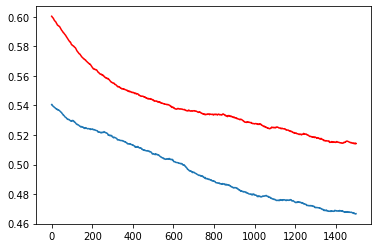

In [7]:
loss_over_time= np.loadtxt('./train_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
test_error= np.loadtxt('./test_loss.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=500

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))

In [8]:
src1, src2, y = collate_fn(10,-100,train=False)
        
src1= src1.to(DEVICE)
src2= src2.to(DEVICE)
    
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)
    
Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)

print(y[0])
#print(Ad[0])
#torch.manual_seed(344)

#Ad = torch.rand(1,3,4)
#print(Ad[0])

f=Ad[0].detach().numpy()

#f=np.repeat(Ad[0].detach().numpy(), [2,2,2], axis=0)

#print('f',f)

row_ind, col_ind = linear_sum_assignment(1-f)

print(row_ind,col_ind)

z=np.zeros(f.shape)


for i,j in zip(row_ind, col_ind):
        z[i,j]=1

#print('z',z)        
        
z2 = np.zeros(f.shape)
zero_col=np.where(~z.any(axis=0))[0]
ind=torch.argmax(Ad[0][:,zero_col], dim=0)
        
print(Ad[0][:,zero_col])        
print(np.where(~z.any(axis=0))[0])
print(ind)
print(z)

for k,l in zip(ind,zero_col):
    z2[k,l]=1
    
print(z+z2)    

pp_A=postprocess(Ad)

#print(pp_A[0])

tensor([[0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]])
[0 1 2 3 4 5] [1 2 6 3 4 5]
tensor([[0.0021],
        [1.0000],
        [0.0692],
        [0.9985],
        [0.3015],
        [0.0259]], grad_fn=<IndexBackward0>)
[0]
tensor([1])
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [15]:
#recon
run=13
src1, src2, y = collate_fn(26,-100,recon=True,train=False,run=run)

print(src1.size())
src1= src1.to(DEVICE)
src2= src2.to(DEVICE)
    
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)
    
Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
pp_A=postprocess_2(Ad)

print('y',y[0])
print('Ad',Ad[0])
print('pp',pp_A[0])

for i in range(14):
    print(pp_A[i])
    
    
make_reconstructed_edgelist(pp_A,run=run)

recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
recon
torch.Size([14, 26, 24])
y tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Ad tensor([[1.0000e+00, 1.2523e-03, 4.2685e-01],
        [1.4013e-04, 9.9998e-01, 3.5553e-04],
        [5.6119e-01, 3.4038e-01, 9.9999e-01]], grad_fn=<SliceBackward0>)
pp [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[0. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 0. 0.]]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 1. 0

0

In [10]:


x=np.arange(1,51,dtype=int)
y=np.arange(1,7,dtype=int)

l=[]
for i in range(5):
    z=np.random.choice(x, replace=False)
    l.append(z)
print(l)
s=np.random.random_integers(12)
print(s)
s=np.random.random_integers(12)
print(s)

[6, 13, 10, 6, 18]
9
3


/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  if __name__ == '__main__':
/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


In [11]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)

print(out.shape)

torch.Size([20, 32, 512])


In [18]:
im = Image.open('/home/mo/Desktop/IWR/CellTracking/Fluo-C2DL-Huh7/02_GT/TRA/man_track001.tif')
im.show()

print(np.array(im))

135585


In [12]:
print(stop)

NameError: name 'stop' is not defined

In [ ]:
p_drop=0.05
learning_rate=0.0001 #0.001 for cnn
epochs = 2000
emb_size=6   #!!!!!!!!!!!!!!!!!!!!
seq_length=104
d_m=12*20
nhead= 3
num_encoder_layers=4

model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


#model=MiniLin(ch_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[250,750,1000,1500,2000,2500], gamma=0.5)


loss_function = nn.MSELoss(reduction='sum')

#loss_function = myL_loss(100,100)


model, loss_over_time, test_error = train_easy(model, optimizer, loss_function, epochs, scheduler,verbose=True,eval=True)

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
PAD_IDX=0



a = torch.ones(5, 6)*2
b = torch.ones(2, 6)
c = torch.ones(4, 6)
c2 = torch.ones(4, 6)/2

print(c)
print(c2)


#torch.matmul(d, e) 




d = pad_sequence([a, c])
e = pad_sequence([b, c2])




#print(d.size(),e.size())
#print('d',d[:,1,:],d[:,1,:].size())

mask1=create_mask(d,PAD_IDX)
mask2=create_mask(e,PAD_IDX)


d=torch.transpose(d,0,1)
e=torch.transpose(e,0,1)
e=torch.transpose(e,1,2)

#print('d2',d,d.size(),d[1,:,:])
#print('e2',e,e.size(),e[1,:,:])


#d=torch.reshape(d, (d.size(1), d.size(0), d.size(2)))
#e=torch.reshape(e, (e.size(1), e.size(2), e.size(0)))


#print(d,d.size())
#print('e',e,e.size(),e[0,:,:])



z=torch.bmm(d,e)

#print(z[0],z[1])
print(mask1[1],mask2[1])

#model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)

#out=model(d,e,mask1,mask2)
#print(out.size())


mA=makeAdja()
Ad=mA.forward(z,mask1,mask2)

print(Ad.size())

In [ ]:
print(stop)

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        print('PE',token_embedding.size(),self.pos_embedding[:token_embedding.size(0), :].size())
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        
        #print('trans_src_before_pos',src,src.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        print('trans_src',src_emb,src_emb.size())
        print('trans_src_padd',src_padding_mask,src_padding_mask.size())
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        print('outs',outs.size())
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    print('src_size',src.size())
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    #print('batch',len(batch),batch)
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        #print('src_sample',src_sample)
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        #print('emb',src_batch[-1])
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        
        
        #print('trainsrc',src,src.size())

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        #print('trainsrc_padd',src_padding_mask,src_padding_mask.size())

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))